# Dependencies

In [1]:
!git clone https://github.com/voxelmorph/voxelmorph.git # getting vxm from git to use scripts
!pip install neurite

Cloning into 'voxelmorph'...
remote: Enumerating objects: 3240, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3240 (delta 14), reused 30 (delta 11), pack-reused 3202
Receiving objects: 100% (3240/3240), 129.20 MiB | 23.09 MiB/s, done.
Resolving deltas: 100% (2078/2078), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.3-py3-none-any.whl size=19530 sha256=c89c6aeda3af491a21fac5d2ce92d76fccf706a6e8ebdb1d01d168a267c582ee
  Stored in directory: /root/.cache/pip/wheels/33/42/e2/6312e2cd3efadacc2714759efc7c7dc1513db7853e8bd508f6
Successfully built pystrum


In [2]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import sys 
sys.path.append('voxelmorph')
import voxelmorph as vxm
import time

import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

np.random.seed(777)
tf.random.set_seed(777)

# disable eager execution
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.experimental.output_all_intermediates(True) # https://github.com/tensorflow/tensorflow/issues/54458

# Connect to driver

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Download dataset OASIS

In [5]:
# get neurite-OASIS data
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
!mkdir OASIS
!tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS'

--2023-06-03 01:17:38--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘neurite-oasis.2d.v1.0.tar’

neurite-oasis.2d.v1 100%[===================>]  23.75M  8.18MB/s    in 2.9s    

2023-06-03 01:17:42 (8.18 MB/s) - ‘neurite-oasis.2d.v1.0.tar’ saved [24903680/24903680]



# Download train and validation list

In [6]:
!cp "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Utils/processing-oasis-2d-results/train.txt" "/content/"

In [7]:
!cp "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Utils/processing-oasis-2d-results/validate.txt" "/content/"

# Train

In [4]:
# training parameters
class TrainArgs:
  img_list: str = 'train.txt'
  img_prefix: str = None
  img_suffix: str = None
  atlas: str = None
  model_dir: str = 'models'
  multichannel: bool = False
  gpu: int = 0
  batch_size: int = 1
  epochs: int = 1500
  steps_per_epoch: int = 100
  load_weights: str = None
  initial_epoch: int = 0
  lr: float = 1e-4
  enc: list = None
  dec: list = None
  int_steps: int = 7
  int_downsize: int = 2
  use_probs: bool = False
  bidir: bool = False
  image_loss: str = 'mse'
  lambda_weight: float = 0.01
  kl_lambda: float = 10
  image_sigma: float = 1.0

train_args = TrainArgs()
train_args.epochs = 2000

# load and prepare training data
train_files = vxm.py.utils.read_file_list(train_args.img_list, prefix=train_args.img_prefix,
                                          suffix=train_args.img_suffix)
assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not train_args.multichannel

if train_args.atlas:
    # scan-to-atlas generator
    atlas = vxm.py.utils.load_volfile(train_args.atlas, np_var='vol',
                                      add_batch_axis=True, add_feat_axis=add_feat_axis)
    generator = vxm.generators.scan_to_atlas(train_files, atlas,
                                             batch_size=train_args.batch_size,
                                             bidir=train_args.bidir,
                                             add_feat_axis=add_feat_axis)
else:
    # scan-to-scan generator
    generator = vxm.generators.scan_to_scan(
        train_files, batch_size=train_args.batch_size, bidir=train_args.bidir, add_feat_axis=add_feat_axis)

# extract shape and number of features from sampled input
sample_shape = next(generator)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

# prepare model folder
model_dir = train_args.model_dir
os.makedirs(model_dir, exist_ok=True)

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(train_args.gpu)
assert np.mod(train_args.batch_size, nb_devices) == 0, \
    'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (train_args.batch_size, nb_devices)

# unet architecture
enc_nf = train_args.enc if train_args.enc else [16, 32, 32, 32]
dec_nf = train_args.dec if train_args.dec else [32, 32, 32, 32, 32, 16, 16]

# prepare model checkpoint save path
save_filename = os.path.join(model_dir, '{epoch:04d}.h5')

# build the model
model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=train_args.bidir,
    use_probs=train_args.use_probs,
    int_steps=train_args.int_steps,
    int_resolution=train_args.int_downsize,
    src_feats=nfeats,
    trg_feats=nfeats
)

# load initial weights (if provided)
if train_args.load_weights:
    model.load_weights(train_args.load_weights)

# prepare image loss
if train_args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif train_args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE(train_args.image_sigma).loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % train_args.image_loss)

# need two image loss functions if bidirectional
if train_args.bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]

# prepare deformation loss
if train_args.use_probs:
    flow_shape = model.outputs[-1].shape[1:-1]
    losses += [vxm.losses.KL(train_args.kl_lambda, flow_shape).loss]
else:
    losses += [vxm.losses.Grad('l2', loss_mult=train_args.int_downsize).loss]

weights += [train_args.lambda_weight]

# multi-gpu support
if nb_devices > 1:
    save_callback = vxm.networks.ModelCheckpointParallel(save_filename)
    model = tf.keras.utils.multi_gpu_model(model, gpus=nb_devices)
else:
    save_callback = tf.keras.callbacks.ModelCheckpoint(save_filename, 
                                                       save_freq=20 * train_args.steps_per_epoch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=train_args.lr), loss=losses, loss_weights=weights)

# save starting weights
# model.save(save_filename.format(epoch=train_args.initial_epoch))

In [5]:
model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vxm_dense_source_input (InputL  [(None, 160, 192, 1  0          []                               
 ayer)                          )]                                                                
                                                                                                  
 vxm_dense_target_input (InputL  [(None, 160, 192, 1  0          []                               
 ayer)                          )]                                                                
                                                                                                  
 vxm_dense_unet_input_concat (C  (None, 160, 192, 2)  0          ['vxm_dense_source_input[0][0]', 
 oncatenate)                                                      'vxm_dense_target_input[

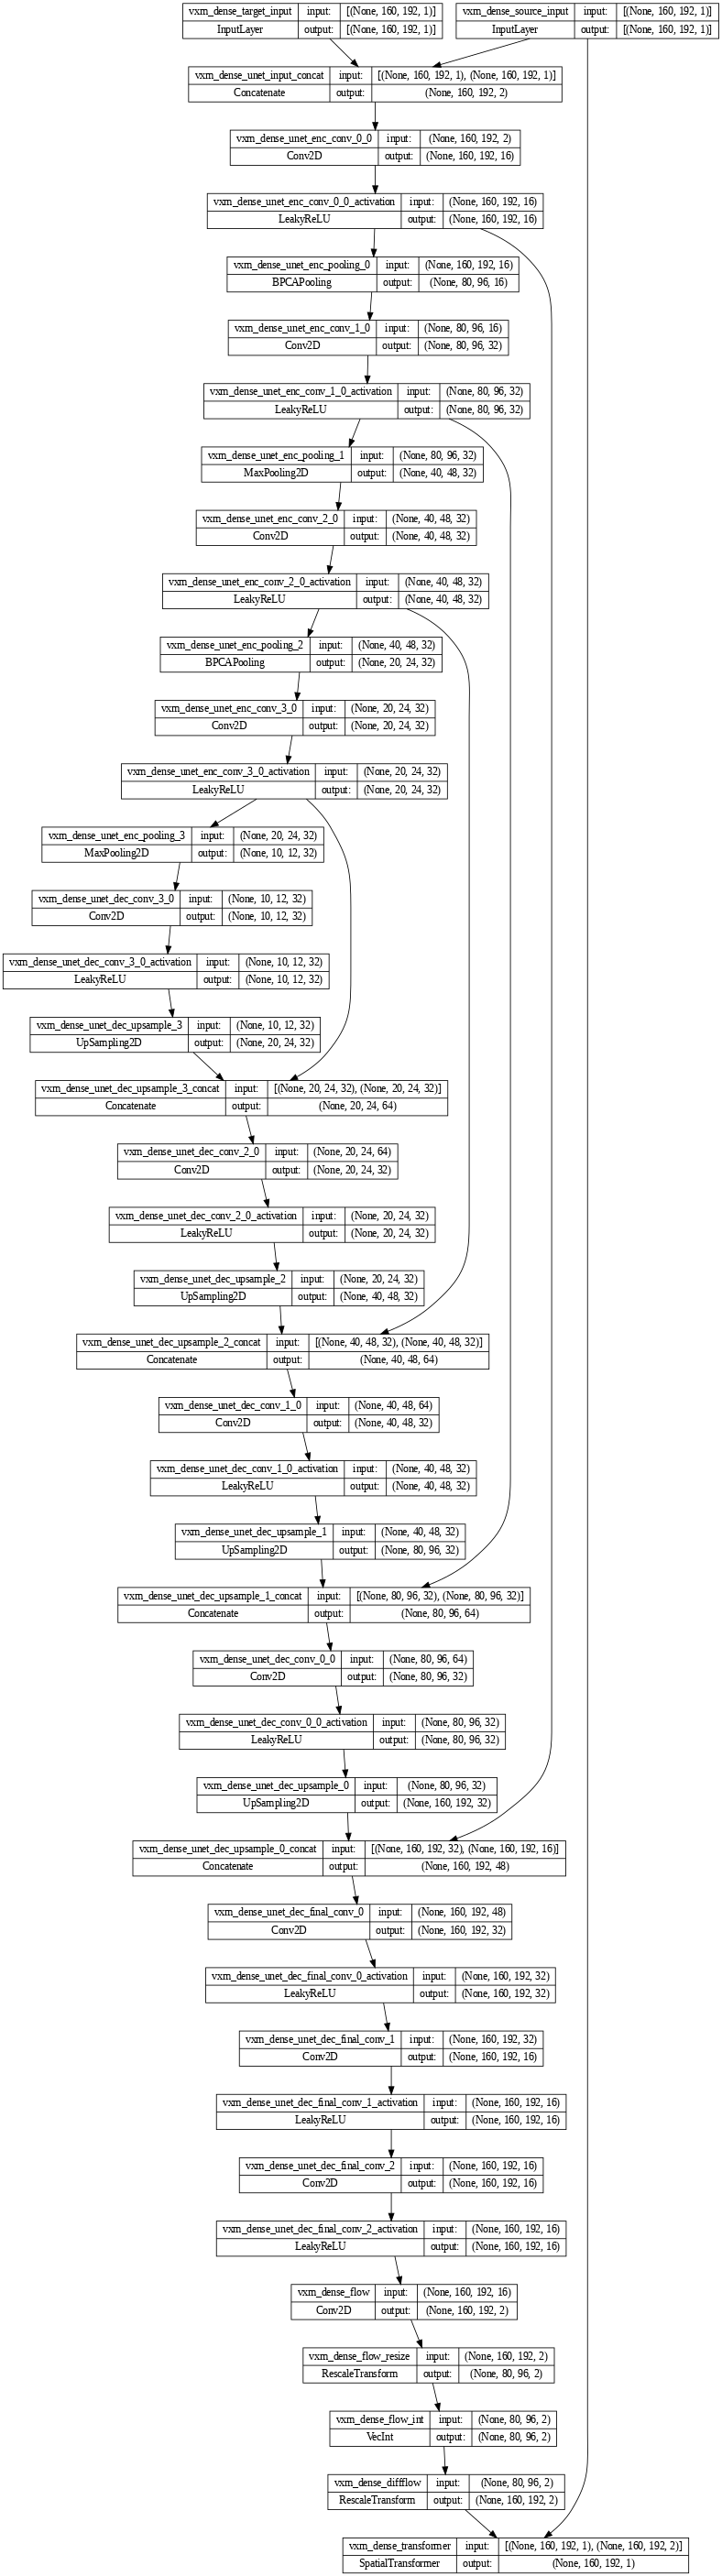

In [6]:
tf.keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [7]:
start_time = time.time()

hist = model.fit(generator,
         initial_epoch=train_args.initial_epoch,
         epochs=train_args.epochs,
         steps_per_epoch=train_args.steps_per_epoch,
         callbacks=[save_callback],
         verbose=1
        )

end_time = time.time()

# saving the model in tensorflow format
model.save(f'./{train_args.epochs}_tf',save_format='tf')
model.save(save_filename.format(epoch=train_args.epochs))

Epoch 1/2000
100/100 [==============================] - 33s 33ms/step - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_resize_loss: 3.6013e-04
Epoch 2/2000
100/100 [==============================] - 3s 34ms/step - loss: 0.0064 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_resize_loss: 0.0050
Epoch 3/2000
100/100 [==============================] - 3s 34ms/step - loss: 0.0055 - vxm_dense_transformer_loss: 0.0051 - vxm_dense_flow_resize_loss: 0.0407
Epoch 4/2000
100/100 [==============================] - 3s 34ms/step - loss: 0.0050 - vxm_dense_transformer_loss: 0.0044 - vxm_dense_flow_resize_loss: 0.0595
Epoch 5/2000
100/100 [==============================] - 3s 34ms/step - loss: 0.0046 - vxm_dense_transformer_loss: 0.0040 - vxm_dense_flow_resize_loss: 0.0651
Epoch 6/2000
100/100 [==============================] - 4s 35ms/step - loss: 0.0044 - vxm_dense_transformer_loss: 0.0037 - vxm_dense_flow_resize_loss: 0.0681
Epoch 7/2000
100/100 [=========================

In [8]:
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 6967.345016956329 seconds


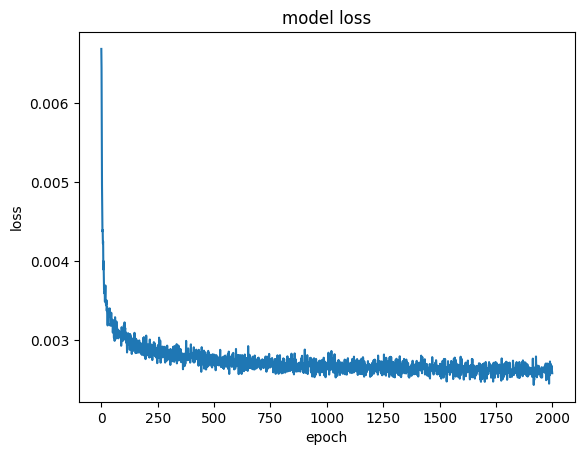

In [9]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
min(hist.history['loss'])

0.0024373051710426807

In [11]:
min(hist.history['vxm_dense_transformer_loss'])

0.0016693020006641746

In [12]:
min(hist.history['vxm_dense_flow_resize_loss'])

0.0003601270145736635

In [13]:
with open('2000-epochs-loss.txt','w') as tfile:
  tmp = [str(value) for value in hist.history['loss']]
  tfile.write('\n'.join(tmp))

with open('2000-epochs-vxm-dense-transformer-loss.txt','w') as tfile:
  tmp = [str(value) for value in hist.history['vxm_dense_transformer_loss']]
  tfile.write('\n'.join(tmp))
 
with open('2000-epochs-vxm_dense-flow-resize-loss.txt','w') as tfile:
  tmp = [str(value) for value in hist.history['vxm_dense_flow_resize_loss']]
  tfile.write('\n'.join(tmp))

In [14]:
!zip -r 2000-epochs-BPCA-MaxPooling-models.zip /content/models/
!zip -r 2000-epochs-BPCA-MaxPooling-tf.zip /content/2000_tf/

  adding: content/models/ (stored 0%)
  adding: content/models/0920.h5 (deflated 15%)
  adding: content/models/1600.h5 (deflated 15%)
  adding: content/models/1240.h5 (deflated 15%)
  adding: content/models/1760.h5 (deflated 15%)
  adding: content/models/0160.h5 (deflated 15%)
  adding: content/models/1400.h5 (deflated 15%)
  adding: content/models/1020.h5 (deflated 15%)
  adding: content/models/0760.h5 (deflated 15%)
  adding: content/models/0800.h5 (deflated 15%)
  adding: content/models/1300.h5 (deflated 15%)
  adding: content/models/0440.h5 (deflated 15%)
  adding: content/models/0200.h5 (deflated 15%)
  adding: content/models/0980.h5 (deflated 15%)
  adding: content/models/1380.h5 (deflated 15%)
  adding: content/models/0560.h5 (deflated 15%)
  adding: content/models/1700.h5 (deflated 15%)
  adding: content/models/1000.h5 (deflated 15%)
  adding: content/models/1540.h5 (deflated 15%)
  adding: content/models/0100.h5 (deflated 15%)
  adding: content/models/0580.h5 (deflated 15%)
  

In [15]:
!cp 2000-epochs-BPCA-MaxPooling-models.zip "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA + Max Pooling/oasis-2d/"
!cp 2000-epochs-BPCA-MaxPooling-tf.zip "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA + Max Pooling/oasis-2d/"

In [16]:
!cp 2000-epochs-loss.txt "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA + Max Pooling/oasis-2d/"
!cp 2000-epochs-vxm-dense-transformer-loss.txt "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA + Max Pooling/oasis-2d/"
!cp 2000-epochs-vxm_dense-flow-resize-loss.txt "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA + Max Pooling/oasis-2d/"

# Layers output

In [17]:
def get_plotting_matrix_shape(num):
    """
    Given a number, returns the number of columns and the number of rows needed for a plotting matrix.
    """
    sqrt = int(num ** 0.5)
    if sqrt ** 2 == num:
        return sqrt, sqrt
    else:
        for i in range(sqrt, 0, -1):
            if num % i == 0:
                return num // i, i

In [18]:
def visualize_output_layer(model, layer_name):
  layer_output=model.get_layer(layer_name).output

  # load moving and fixed images
  fixed = vxm.py.utils.load_volfile(train[55], add_batch_axis=True, add_feat_axis=True)
  moving = vxm.py.utils.load_volfile(train[0], add_batch_axis=True, add_feat_axis=True)

  intermediate_model=tf.keras.models.Model(
      inputs=model.input,
      outputs=layer_output
  )

  with tf.device(device):
    intermediate_prediction=intermediate_model.predict(
        [moving, fixed]
    )

  row_size, col_size = get_plotting_matrix_shape(np.shape(intermediate_prediction)[-1])

  img_index=0
  print(np.shape(intermediate_prediction))

  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8))
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
      img_index+=1


In [19]:
train = []
with open("train.txt", "r") as tfile:
  for line in tfile:
    train = [line.strip() for line in tfile.readlines()]

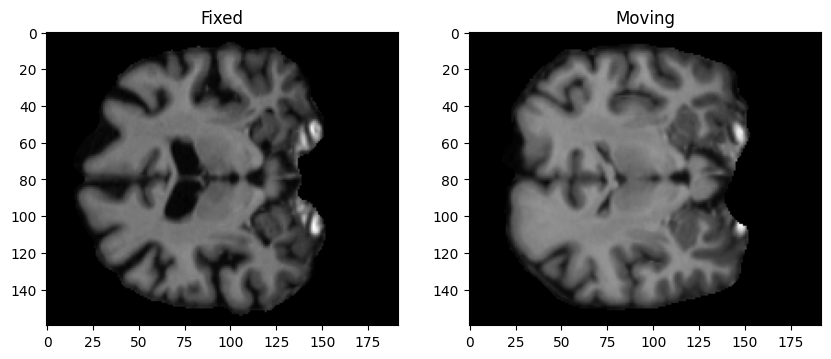

In [20]:
# Load the two images
fixed = vxm.py.utils.load_volfile(train[55], add_batch_axis=True, add_feat_axis=True)
moving = vxm.py.utils.load_volfile(train[0], add_batch_axis=True, add_feat_axis=True)

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# Plot the fixed image on the left subplot
axs[0].imshow(fixed.reshape(160,192), cmap='gray')
axs[0].set_title('Fixed')

# Plot the moving image on the right subplot
axs[1].imshow(moving.reshape(160,192), cmap='gray')
axs[1].set_title('Moving')

# Display the figure
plt.show()

1/1 [==============================] - 0s 471ms/step
(1, 80, 96, 16)


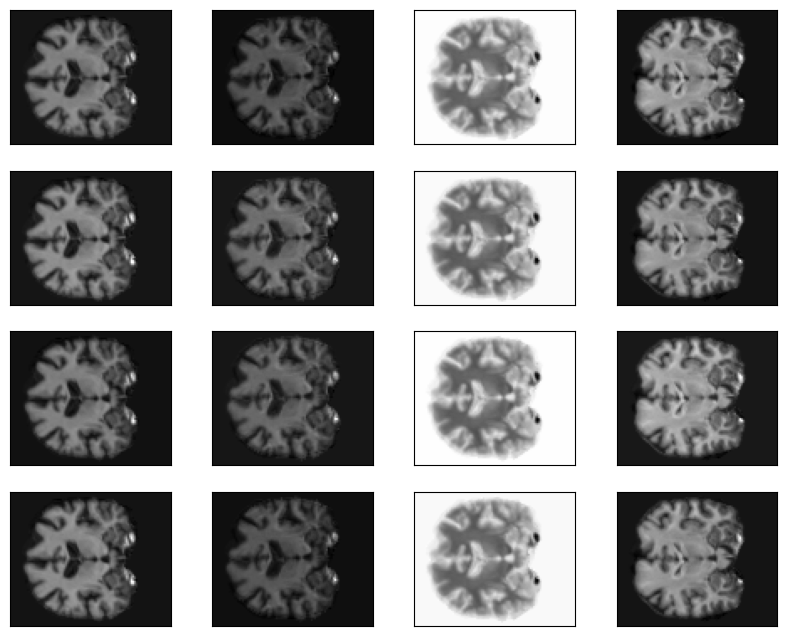

In [21]:
visualize_output_layer(
    model,
    'vxm_dense_unet_enc_pooling_0',
)

1/1 [==============================] - 0s 435ms/step
(1, 40, 48, 32)


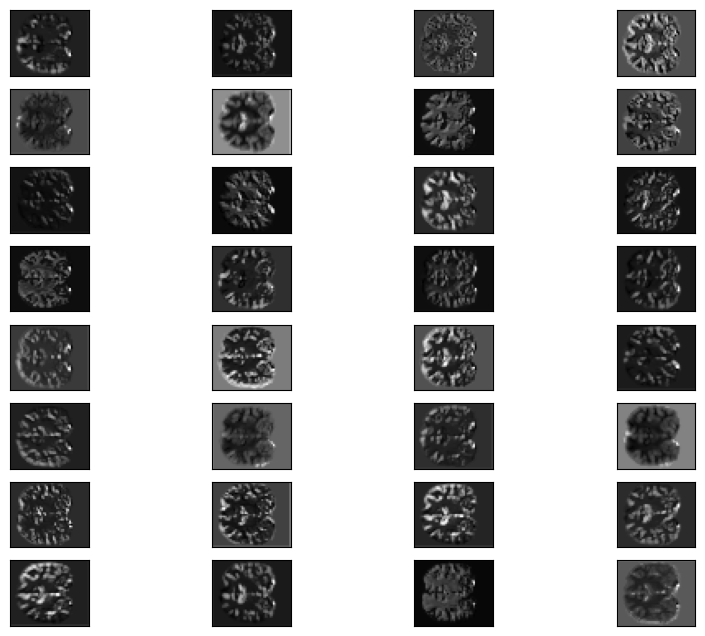

In [22]:
visualize_output_layer(
    model,
    'vxm_dense_unet_enc_pooling_1',
)

# Registration

## Load validate dataset

In [23]:
validate = []
with open("validate.txt", "r") as tfile:
    validate = [line.strip() for line in tfile.readlines()]

## Brains

In [24]:
validate[0]

'/content/OASIS/OASIS_OAS1_0006_MR1/slice_norm.nii.gz'

In [25]:
validate[1]

'/content/OASIS/OASIS_OAS1_0010_MR1/slice_norm.nii.gz'

In [26]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[0]
registration_args.moving = validate[1]
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(
    registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(registration_args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 227ms/step


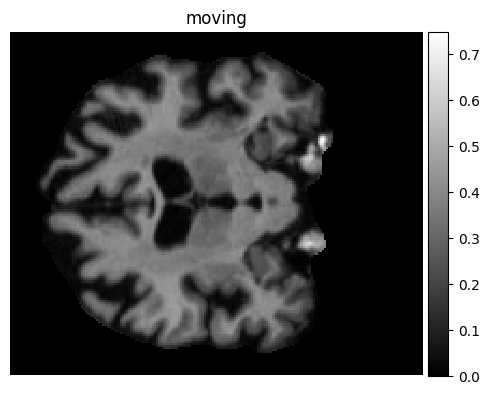

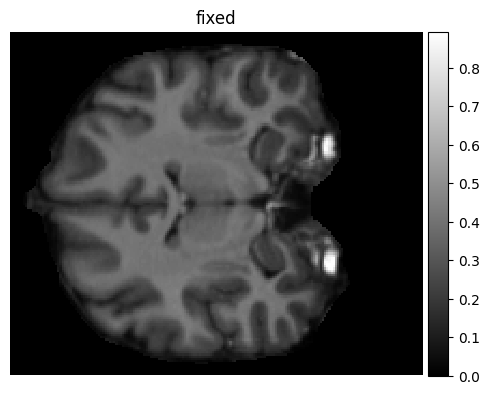

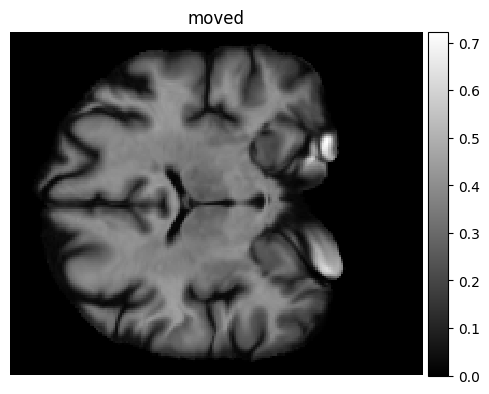

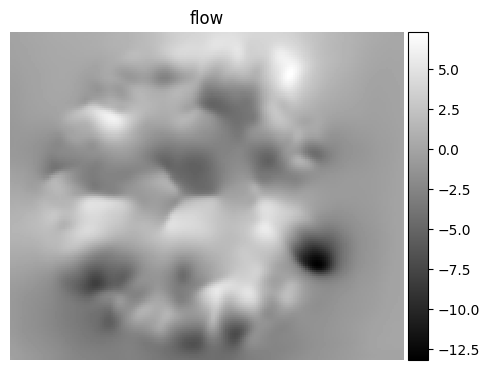

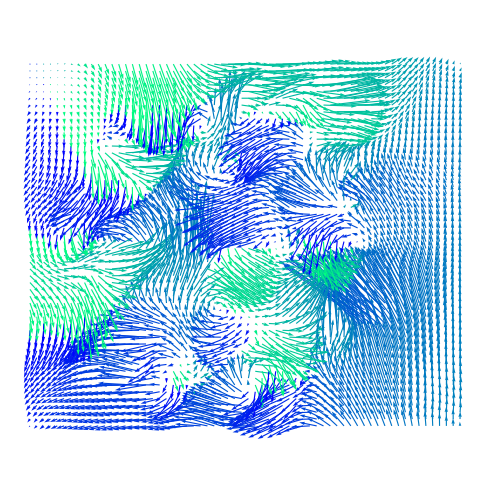

In [27]:
titles = ['moving', 'fixed', 'moved', 'flow']
for index, image in enumerate([moving, fixed, moved, warp]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

print()
print()

## Slice seg24

In [28]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[0].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moving = validate[1].replace('slice_norm.nii.gz', 'slice_seg24.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 238ms/step


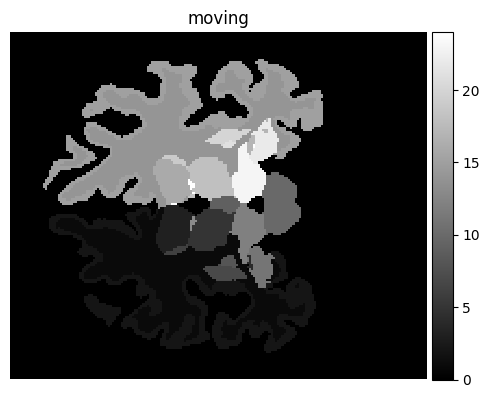

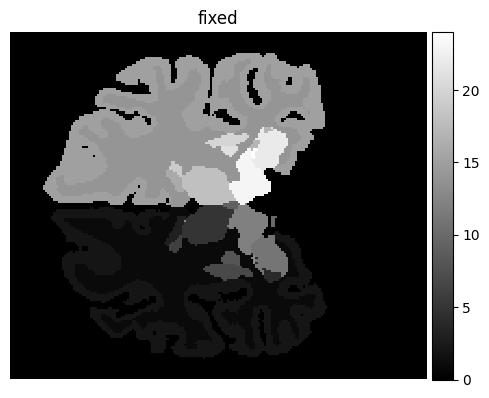

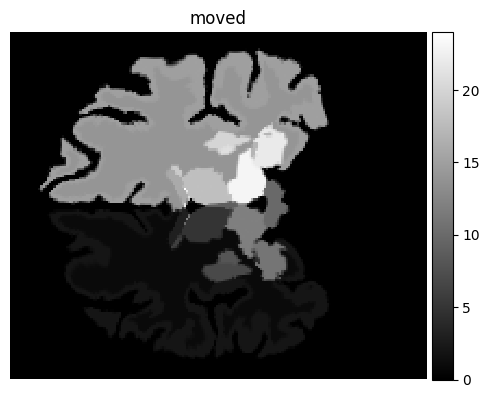

In [29]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

## Slice seg4

In [30]:
class RegistrationArgs:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

registration_args = RegistrationArgs()
registration_args.fixed = validate[0].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moving = validate[1].replace('slice_norm.nii.gz', 'slice_seg4.nii.gz')
registration_args.moved = 'moved.nii.gz'
registration_args.warp = 'warp.nii.gz'
registration_args.model = '/content/models/2000.h5'
registration_args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(registration_args.gpu)

# load moving and fixed images
add_feat_axis = not registration_args.multichannel
moving = vxm.py.utils.load_volfile(registration_args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

fixed, fixed_affine = vxm.py.utils.load_volfile(registration_args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

val_pred = moved

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warped_seg = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

1/1 [==============================] - 0s 233ms/step


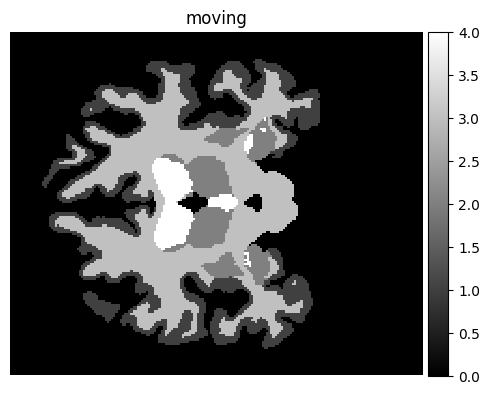

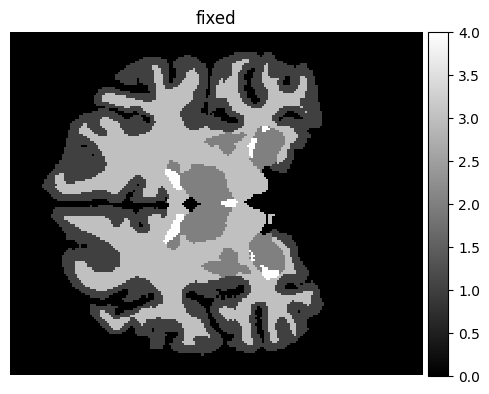

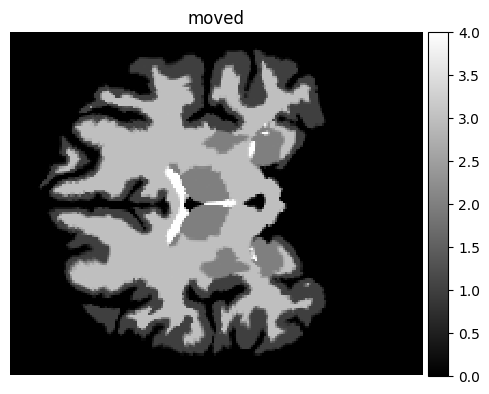

In [31]:
titles = ['moving', 'fixed', 'moved']

for index, image in enumerate([moving, fixed, warped_seg]):
  images = [img[0, :, :, 0] for img in [image]]
  ne.plot.slices(images, titles=[titles[index]], width=5, cmaps=['gray'], do_colorbars=True);
  print()

print()
print()

# Run scripts

In [ ]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(subj_lst_m))

In [ ]:
%run -i /content/voxelmorph/scripts/tf/train.py \
--img-list 'train_list.txt' \
--epochs 100

In [ ]:
%run /content/voxelmorph/scripts/tf/register.py \
--moving /content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz \
--fixed /content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz \
--moved moved.nii.gz \
--warp warp.nii.gz \
--model /content/models/0100.h5 \
--gpu 0

In [ ]:
%run -i /content/voxelmorph/scripts/tf/test.py \
--model /content/models/0100.h5 \
--pairs /content/pairs.txt \
--img-prefix /content/OASIS/ \
--seg-prefix /content/OASIS/ \
--img-suffix /slice_norm.nii.gz \
--seg-suffix /slice_seg24.nii.gz

# Some annotations

Explain of testing script:

https://github.com/voxelmorph/voxelmorph/issues/373

To make voxelmorph work with the BPCA pooling layer follow these steps:

1. Copy the [BPCA Pooling](https://github.com/Uemerson/masters-degree-in-computer-science-from-unesp/blob/main/utils/BPCAPooling.py)
2. In the /content/voxelmorph/voxelmorph/tf/networks.py file, paste the BPCA Pooling code
2. In the /content/voxelmorph/voxelmorph/tf/networks.py file, replace in the Unet class the following codes:

```
last = MaxPooling(max_pool[level], name='%s_enc_pooling_%d' % (name, level))(last)
```

to:

```
b, w, h, c = last.get_shape()
            
last = BPCAPooling(expected_shape=(w,h,c), name='%s_enc_pooling_%d' % (name, level))(last)
```